In [ ]:
!pip install tensorflow
!pip install --quiet phiflow==3.4 tqdm


  Using cached markdown_it_py-4.0.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 MB 10.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 11.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 11.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.2 MB/s eta 0:00:00a 0:00:01
Using cached markdown_it_py-4.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)


In [1]:
from tqdm import tqdm
from phiml import nn

from phi.torch.flow import *
# this notebook largely works identically with tensorflow - try replacing the line above with this one
# from phi.tf.flow import *  

In [6]:
RES_X = 32
RES_Y = 32

NUM_SAMPLES_TRAIN = 100
BATCH_SIZE = 10

/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_25853/1350259774.py:9: DeprecationWarning: phiml.math.length is deprecated in favor of phiml.math.norm
  plot = vis.plot({ "velocity": vel.batch[0], "vel. magnitude": math.vec_length(vel.batch[0].at_centers().values), "divergence": field.divergence(vel.batch[0]), })
/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phi/vis/_matplotlib/_matplotlib_plots.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # because subplot titles can be added after figure creation


Initial L2 of divergence: 165.68997, max=1.5721590518951416


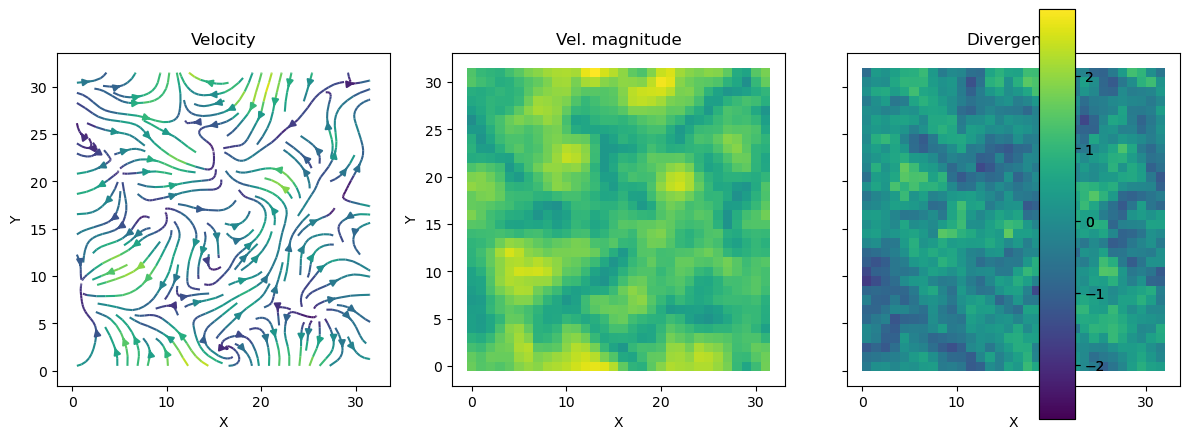

In [7]:
vel = field.StaggeredGrid(
    values=field.Noise(batch(batch=NUM_SAMPLES_TRAIN)),
    extrapolation=math.extrapolation.PERIODIC,
    bounds=geom.Box(x=RES_X, y=RES_Y), 
    resolution=math.spatial(x=RES_X, y=RES_Y),
)

# plot the velocity field
plot = vis.plot({ "velocity": vel.batch[0], "vel. magnitude": math.vec_length(vel.batch[0].at_centers().values), "divergence": field.divergence(vel.batch[0]), })

# for initial assessments, let's print the typical divergence of an input
print( f"Initial L2 of divergence: {math.l2_loss(field.divergence(vel.batch[0]))}, max={field.divergence(vel.batch[0]).values.max}" )

In [8]:
@jit_compile
def step(v, dt = 1.0):
    v = advect.mac_cormack(v, v, dt)
    v, p = fluid.make_incompressible(v, [], solve=Solve(rank_deficiency=0))
    return v, p

v,p = step(vel)

/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phiml/backend/torch/_torch_backend.py:873: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1739474897993/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)


In [10]:
from phiml import nn 

network = nn.u_net(in_channels=1, out_channels=1, levels=4, periodic=True, batch_norm=False, in_spatial=(RES_X, RES_Y), filters=24)

# uncomment this for an alternative architecture that could generalize to different resolutions
#network = nn.res_net(in_channels=1,out_channels=1,layers=[32,32,32])

# print network and parameter summary
from phiml.backend import BACKENDS
if any([b.name == 'torch' for b in BACKENDS]):
    print(network)
    print("Total number of trainable parameters: "+ str( sum(p.numel() for p in network.parameters()) ))
elif any([b.name == 'tf' for b in BACKENDS]):
    network.summary() 

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (1): Identity()
      (2): ReLU()
      (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (4): Identity()
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): ResNetBlock(
      (sample_input): Identity()
      (bn_sample): Identity()
      (bn1): Identity()
      (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Identity()
      (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (up1): Up(
    (up): Upsample(scale_factor=2.0, mode='bilinear')
    (conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)


In [11]:
@jit_compile
def eval_nn(v):
    nn_input = field.divergence(field=v, order=2)
    p = math.native_call(network, nn_input.values)
    p = field.CenteredGrid(
        values=p,
        extrapolation=math.extrapolation.PERIODIC, 
        bounds=geom.Box(x=RES_X, y=RES_Y),
        resolution=spatial(x=RES_X, y=RES_Y),
    )
    grad_pres = field.spatial_gradient(p, boundary=math.extrapolation.PERIODIC, at=v.sampled_at) 
    v = v - grad_pres
    return v, p

# loss functions

@jit_compile
def loss_div(v):
    div = field.divergence(field=v,order=2)
    div_sum = 2 * math.l2_loss(div)
    return div_sum, div

@jit_compile
def loss_func(v):
    v, p = eval_nn(v)
    loss, div = loss_div(v)  
    return math.mean(loss,dim=batch), v, p

Loss for untrained network: 331.3662


/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phi/vis/_matplotlib/_matplotlib_plots.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # because subplot titles can be added after figure creation


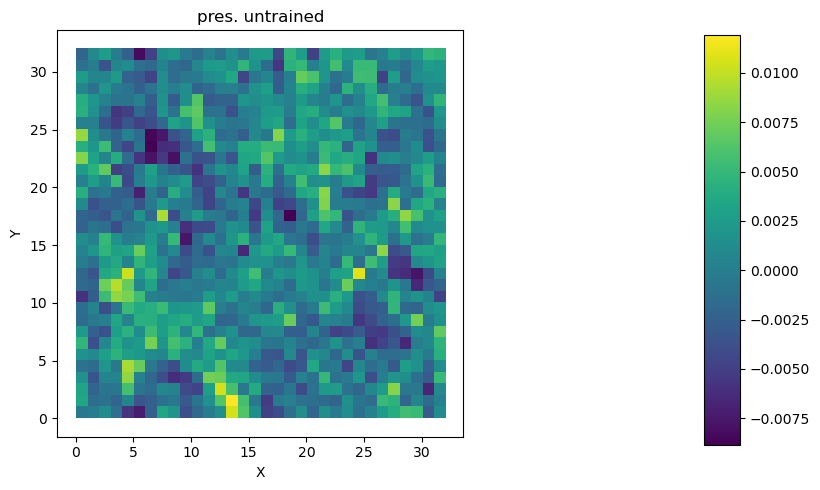

In [12]:
vel_untrained, pres_untrained = eval_nn(vel.batch[0])

# optionally, visualize the outputs: this doesn't look much different from before as the NN is untrained
#plot = vis.plot( {"vel untrained": vel_untrained, "vel len. untrained": math.vec_length(vel_untrained.at_centers().values), "div. untrained": field.divergence(vel_untrained), })

# print the loss and divergence sum of the corrected velocity from untrained NN
loss, div_untrained = loss_div(vel_untrained)
print(f"Loss for untrained network: {loss}")

# also, we visualize the pressure field
plot = vis.plot(pres_untrained,title="pres. untrained")

In [13]:
optimizer = nn.adam(network, learning_rate=5e-3)
for epoch in tqdm(range(15)):
    for b in range(int(NUM_SAMPLES_TRAIN / BATCH_SIZE)):
        vel_input = vel.batch[b*BATCH_SIZE:b*BATCH_SIZE + BATCH_SIZE]
        loss, pred_v, pred_p = nn.update_weights(
            network, optimizer, loss_func, vel_input
        )

loss, _,_ = loss_func(vel)
print(f"Final loss={loss.numpy()}")  

  0%|          | 0/15 [00:00<?, ?it/s]/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phiml/backend/torch/_torch_backend.py:1164: RuntimeWarning: PyTorch does not support nested tracing. The inner JIT of native(eval_nn) will be ignored.
  warnings.warn(f"PyTorch does not support nested tracing. The inner JIT of {self.f.__name__} will be ignored.", RuntimeWarning)
/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phiml/backend/torch/_torch_backend.py:1164: RuntimeWarning: PyTorch does not support nested tracing. The inner JIT of native(loss_div) will be ignored.
  warnings.warn(f"PyTorch does not support nested tracing. The inner JIT of {self.f.__name__} will be ignored.", RuntimeWarning)
/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phiml/backend/torch/_torch_backend.py:1164: RuntimeWarning: PyTorch does not support nested tracing. The inner JIT of native(eval_nn) will be ignored.
  warnings.warn(f"PyTorch does not support nested tracing. The inner JIT of {self.f.__na

Final loss=0.7721096277236938


/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phiml/backend/torch/_torch_backend.py:1164: RuntimeWarning: PyTorch does not support nested tracing. The inner JIT of native(loss_div) will be ignored.
  warnings.warn(f"PyTorch does not support nested tracing. The inner JIT of {self.f.__name__} will be ignored.", RuntimeWarning)


In [14]:
NUM_SAMPLES_TEST = 10

vel_test = field.StaggeredGrid(
    values=field.Noise(math.batch(batch=NUM_SAMPLES_TEST),scale=2.), 
    extrapolation=math.extrapolation.PERIODIC,
    bounds=geom.Box(x=RES_X, y=RES_Y),
    resolution=math.spatial(x=RES_X, y=RES_Y),
)

/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phiml/backend/_linalg.py:345: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x = spsolve(lin[batch], y[batch])  # returns nan when diverges


Original, mean divergence=2153.371, div. max=4.663
NN, mean divergence=12.446, div. max=0.434
Solver, mean divergence=0.000, div. max=0.000


/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phi/vis/_matplotlib/_matplotlib_plots.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # because subplot titles can be added after figure creation


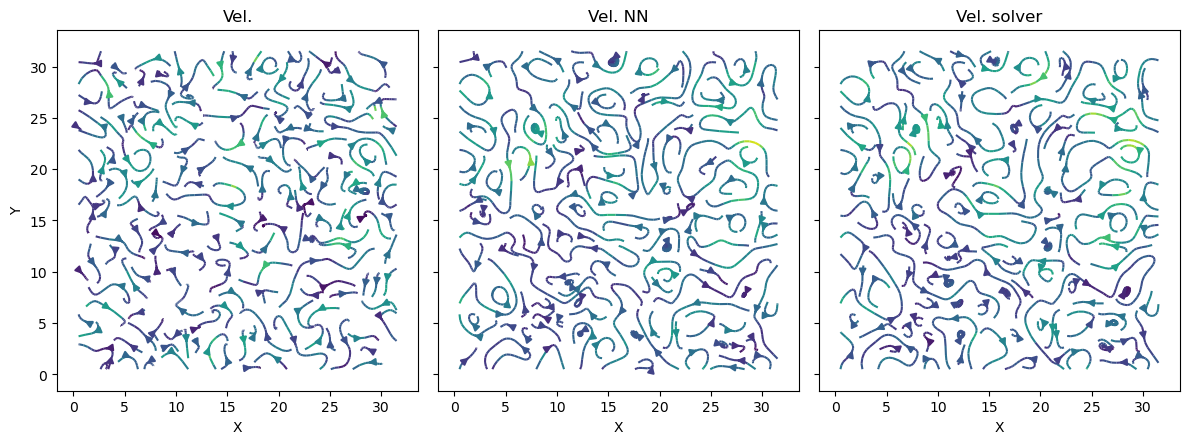

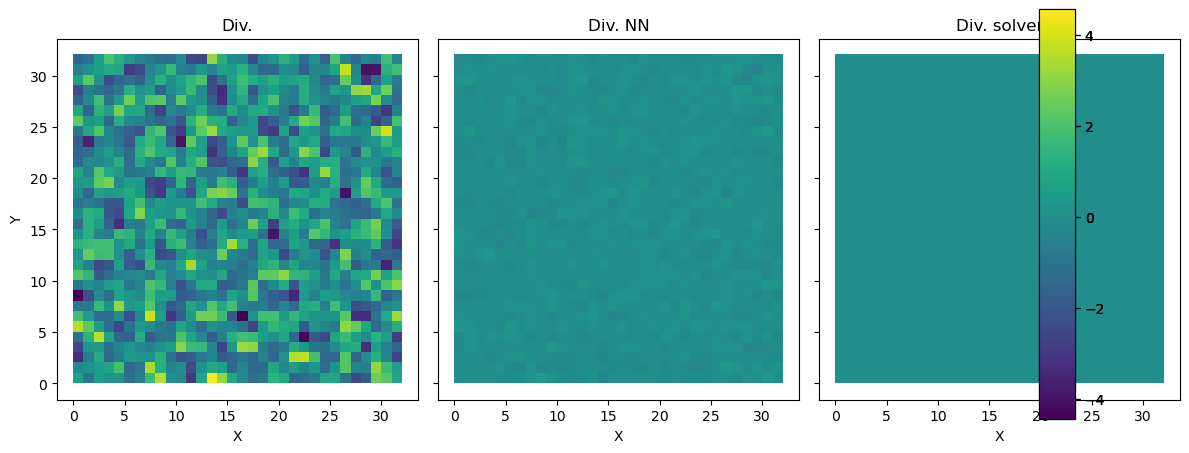

In [15]:
vel_nn, p_nn          = eval_nn(vel_test)
vel_solver, p_solver  = fluid.make_incompressible(vel_test, [])

loss, div = loss_div(vel_test)
print(f"Original, mean divergence={loss.mean:.3f}, div. max={math.max(div.values).mean:.3f}")

loss, div = loss_div(vel_nn)
print(f"NN, mean divergence={loss.mean:.3f}, div. max={math.max(div.values).mean:.3f}")

loss, div = loss_div(vel_solver)
print(f"Solver, mean divergence={loss.mean:.3f}, div. max={math.max(div.values).mean:.3f}")

plot = vis.plot({ "vel.": vel_test.batch[0],  "vel. NN": vel_nn.batch[0],  "vel. solver": vel_solver.batch[0] })
plot = vis.plot({ "div.": field.divergence(vel_test.batch[0]), "div. NN": field.divergence(vel_nn.batch[0]), "div. solver": field.divergence(vel_solver.batch[0]), })

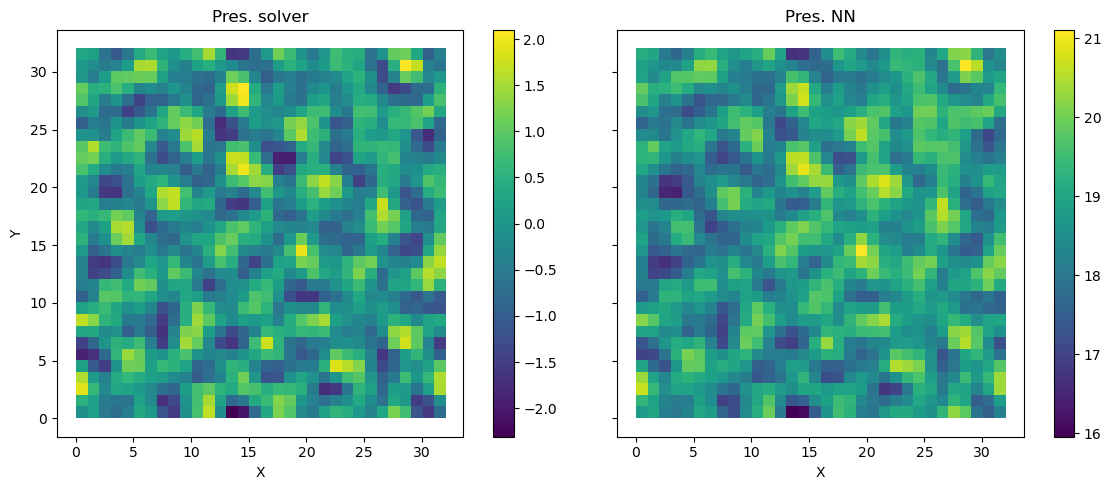

In [16]:
# plot the pressure on the training data, compared with the pressure given by traditional solver.
plot = vis.plot({"pres. solver": p_solver.batch[0], "pres. NN": p_nn.batch[0]}, same_scale=False)

In [17]:
smoke = CenteredGrid(0, extrapolation.PERIODIC, x=RES_X, y=RES_Y, bounds=Box(x=RES_X, y=RES_Y)) 
vel_smk = StaggeredGrid(0, extrapolation.PERIODIC, x=RES_X, y=RES_Y, bounds=Box(x=RES_X, y=RES_Y)) 

RECTANGLE = Obstacle(Box(x=(12, 20), y=(18, 20)))
INFLOW_LOCATION = tensor((16, 5), channel(vector='x,y'))
INFLOW = 0.6 * CenteredGrid(Sphere(center=INFLOW_LOCATION, radius=3), extrapolation.PERIODIC, x=RES_X, y=RES_Y, bounds=Box(x=RES_X, y=RES_Y))
CYLINDER = Obstacle(geom.infinite_cylinder(x=16, y=20, radius=3, inf_dim=None))

In [18]:
dt = 0.1

@jit_compile
def step_nn(v, dt, f, obstacle):
    v = v + f * dt
    v = advect.mac_cormack(v, v, dt)
    v = fluid.apply_boundary_conditions(v, obstacle)
    nn_input = field.divergence(field=v, order=2)
    p = math.native_call(network, nn_input.values)

    p = field.CenteredGrid( values=p,
        extrapolation=math.extrapolation.PERIODIC,
        bounds=geom.Box(x=RES_X, y=RES_Y),
        resolution=spatial(x=RES_X, y=RES_Y),
    )
    grad_pres = field.spatial_gradient(p, at=v.sampled_at) 
    v = v - grad_pres
    v = fluid.apply_boundary_conditions(v, obstacle)
    return v, p

@jit_compile
def step_obs(v, dt, f, obstacle):
    v = v + f * dt
    v = advect.mac_cormack(v, v, dt)
    v, p = fluid.make_incompressible(v, obstacle, solve=Solve(rank_deficiency=0))
    return v, p

100%|██████████| 50/50 [00:05<00:00,  8.63it/s]
/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phi/vis/_matplotlib/_matplotlib_plots.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # because subplot titles can be added after figure creation


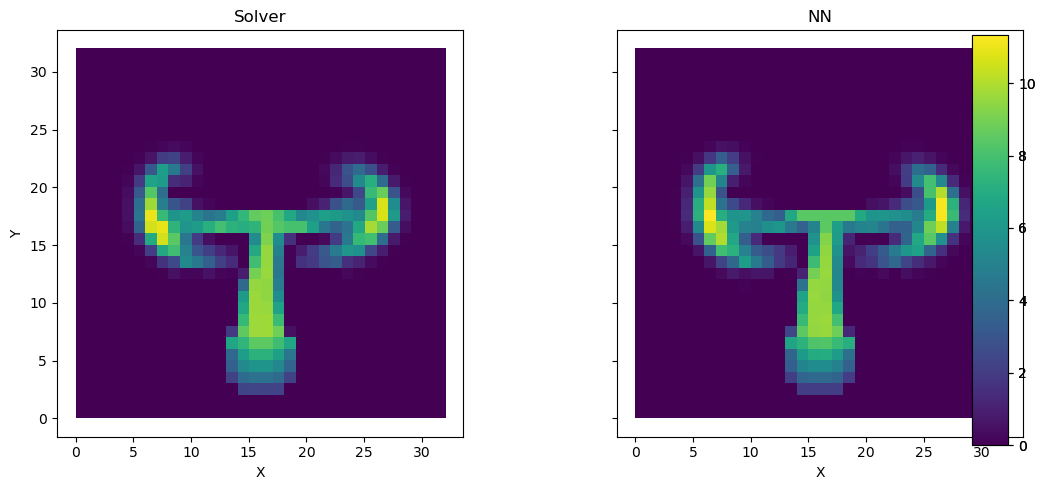

In [19]:
STEPS = 50
smk_solv = smoke
smk_nn = smoke
vel_smk_solv = vel_smk
vel_smk_nn = vel_smk
traj_smk_solv = [smk_solv]
traj_smk_nn = [smk_nn]

# flexible backends require a small workaround for PyTorch's no_grad context here; by default (eg for TF) use a null-context
from contextlib import nullcontext 
context = nullcontext() 
if any([b.name == 'torch' for b in BACKENDS]):
    context = torch.no_grad()

with context:
    for i in tqdm(range(STEPS)):
        smk_solv = advect.mac_cormack(smk_solv, vel_smk_solv, dt=dt) + INFLOW
        smk_nn = advect.mac_cormack(smk_nn, vel_smk_nn, dt=dt) + INFLOW
        
        buoyancy_force_solv = smk_solv * (0, 1.0) @ vel_smk_solv
        buoyancy_force_nn = smk_nn * (0, 1.0) @ vel_smk_nn
        
        vel_smk_solv, _ = step_obs(vel_smk_solv, dt, buoyancy_force_solv, [RECTANGLE])
        vel_smk_nn, _ = step_nn(vel_smk_nn, dt, buoyancy_force_nn, [RECTANGLE])
        
        traj_smk_solv.append(smk_solv)
        traj_smk_nn.append(smk_nn)

traj_smk_solv = field.stack(traj_smk_solv, batch('time'))
traj_smk_nn = field.stack(traj_smk_nn, batch('time'))

plot = vis.plot({"Solver": traj_smk_solv.time[STEPS-1], "NN": traj_smk_nn.time[STEPS-1]}) # show last frame